In [1]:
import pandas as pd
import numpy as np
import csv
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import squarify

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle
import re
from collections import Counter
from string import punctuation
import json
from wordcloud import WordCloud
from PIL import Image

import plotly
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.go_offline()

In [83]:
# create column names
col_names=['username','tweet']

# read csv
df_twtr = pd.read_csv('lawansaddiq.csv', names=col_names)

# check head
df_twtr.head()

,username,tweet
0,bevintharaj,🏴🏴🏴 #Lawan
1,vin_der_pal,@faiqahff @BBCWorld @BuzzFeedWorld @AJEnglish ...
2,syedaidibb,#Lawan #KerajaanBangsat https://t.co/PZvR0oUPZ3
3,ayambakaq,#BenderaHitam BANGKITLAH RAKYAT-RAKYAT SEKALIA...
4,nama_90s,@malaysiakini @IsmailSabri60 @MuhyiddinYassin ...


In [84]:
df_twtr.to_pickle('df_hashtaglawan.p') # save dframe to pickle

In [2]:
df_lawan = pd.read_pickle('df_saddiqlawan.p')  # load from pickle

In [3]:
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', str(tweet))
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','', str(tweet))
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', str(tweet))
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', str(tweet))
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', str(tweet))
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', str(tweet))
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', str(tweet))
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', str(tweet))
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________

# clean dataframe's text column
df_lawan['tweet'] = df_lawan['tweet'].apply(processTweet)
# preview some cleaned tweets
print(df_lawan['tweet'])

0                                    penat dengan azmin 
1                                                tahnya 
2      sebab malaysia dah macam menuju kehancuran den...
3      because need change malaysia better one better...
4                                untuk generasi hadapan 
                             ...                        
710    woi syed saddiq dulu pun celakalah takyah nak ...
711    dictatorship shows when the government tried n...
712    sbb dah terlalu lama dinosaur tua berkuasa neg...
713    sbb kami penat 2020 2021 terbazir begitu saje ...
714              tak aci ade timb menteri dpt kawin baru
Name: tweet, Length: 715, dtype: object


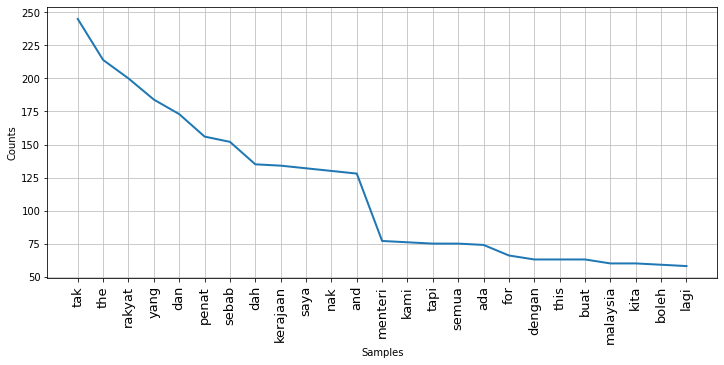

Text(0.5, 0, 'Word Rank')

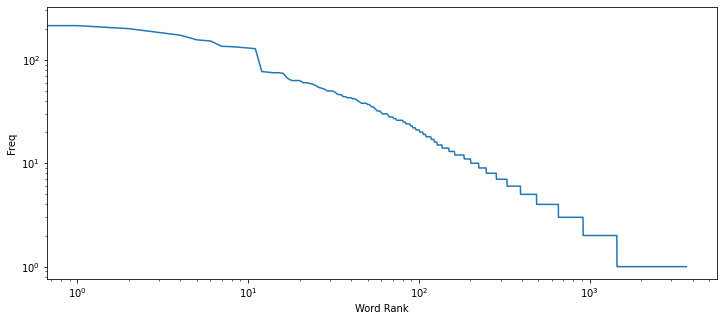

In [4]:
# most common words in twitter dataset
all_words = []
for line in list(df_lawan['tweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)

plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

In [5]:
# drop duplicates
df_lawan = df_lawan.drop_duplicates('tweet')
df_lawan.shape

(690, 2)

In [89]:
export_csv = df_lawan.to_csv('lawanhashtagclean.csv', index = None)

In [6]:
%%time
# tokenize helper function
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in (stopwords.words('english') or stopwords.words('indonesian'))]

def remove_words(word_list):
    remove = ['tengok','atau','mcm','ini','org','aku','takde','bukan','kena','macam','dgn','kalau','apa','tiada','tidak','ada','semua','buat','boleh','lagi','kerana','tak','yang','dan','dah','nak','sebab','saya','kami','kita','tapi','dengan','pun','dari','sbb','untuk','...','“','”','’','…']
    return [w for w in word_list if w not in remove]

# -------------------------------------------

# tokenize message column and create a column for tokens
df_lawan = df_lawan.copy()
df_lawan['tokens'] = df_lawan['tweet'].apply(text_process) # tokenize style 1
df_lawan['tokens_no_stopwords'] = df_lawan['tokens'].apply(remove_words) #tokenize style 2
df_lawan.head()

CPU times: user 1.51 s, sys: 392 ms, total: 1.9 s
Wall time: 1.92 s


,username,tweet,tokens,tokens_no_stopwords
0,nuru1ain_,penat dengan azmin,"[penat, dengan, azmin]","[penat, azmin]"
1,imber,tahnya,[tahnya],[tahnya]
2,fatihrijal_,sebab malaysia dah macam menuju kehancuran den...,"[sebab, malaysia, dah, macam, menuju, kehancur...","[malaysia, menuju, kehancuran, menteri, menter..."
3,dygalanis,because need change malaysia better one better...,"[need, change, malaysia, better, one, better, ...","[need, change, malaysia, better, one, better, ..."
4,admimrn,untuk generasi hadapan,"[untuk, generasi, hadapan]","[generasi, hadapan]"


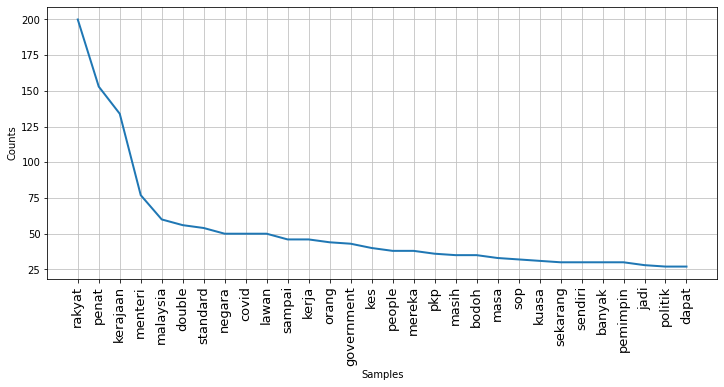

Text(0.5, 0, 'Word Rank')

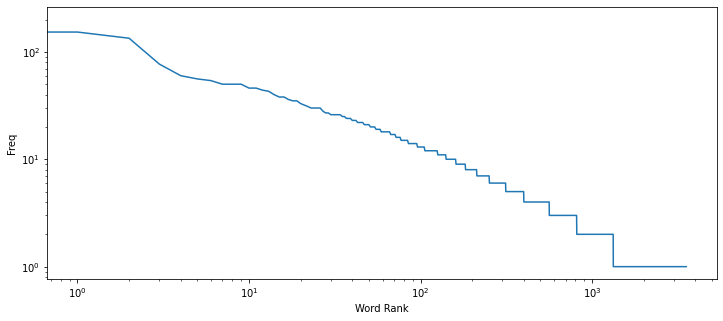

In [7]:
# most common words in twitter dataset
all_words = []
for ls in df_lawan['tokens_no_stopwords']:
    words = [w for w in ls]
    for word in words:
        all_words.append(word.lower())
    
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(30,cumulative=False)

# log-log  of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

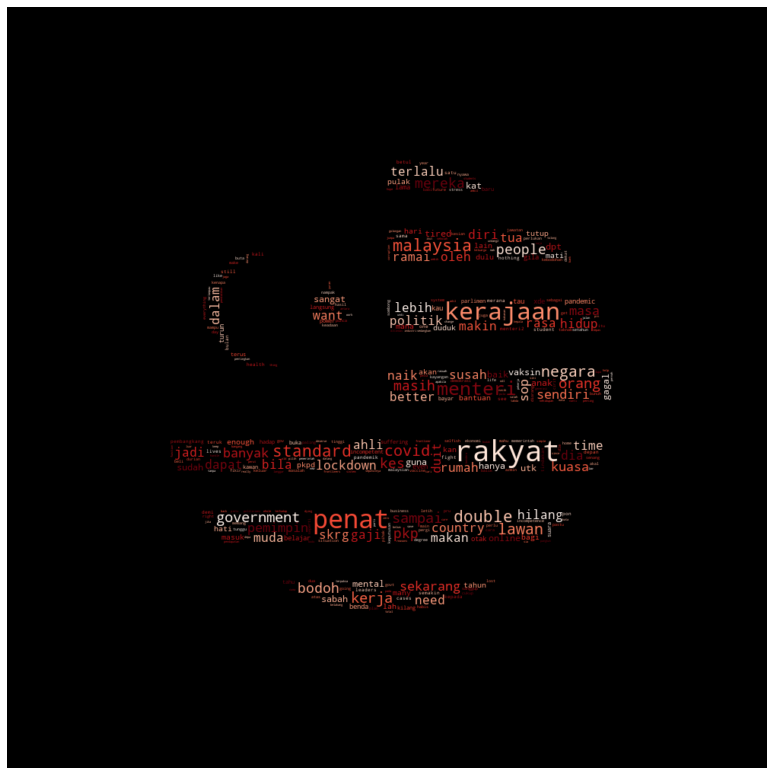

In [10]:
# split sentences to get individual words
all_words = []
for line in df_lawan['tokens_no_stopwords']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)

mask = np.array(Image.open("malaysiaflagcircle.png"))

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      mask=mask,
                      relative_scaling=0.5,
                      colormap='Reds',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [93]:
df = pd.DataFrame.from_dict(wordfreq, orient='index').reset_index()
df

,index,0
0,hit,9
1,200k,50
2,tweets,57
3,hours,8
4,bangkitlah,5
...,...,...
11362,anniversary,1
11363,maha,1
11364,pengasih,1
11365,mudahkanlah,1


In [94]:
df = df.rename(columns={'index':'token', 0:'count'})
df

,token,count
0,hit,9
1,200k,50
2,tweets,57
3,hours,8
4,bangkitlah,5
...,...,...
11362,anniversary,1
11363,maha,1
11364,pengasih,1
11365,mudahkanlah,1


In [95]:
export_csv = df.to_csv('lawanhashtagtokencount.csv', index = None)

In [96]:
wordcloud.to_file("lawanhashtagcloud.png")